## **Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification**

### **EDA: Explore the Data with Relevant Graphs, Statistics, and Insights**

#### **Step 1: Dataset Overview**

In [1]:
import os, shutil, pathlib

original_dir = pathlib.Path("Data/train")
new_base_dir = pathlib.Path("Data/cats_vs_dogs")

def make_subset(subset_name, start_index, end_index):
    print(f"\n Creating subset: {subset_name} ({start_index} to {end_index - 1})")
    print("----")

    for category in ("cat", "dog"):
     
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        copied = 0

        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            if src.exists():
                shutil.copyfile(src, dst)
                copied += 1
            else:
                print(f"Warning: {fname} not found in {original_dir}")

        print(f"Copied {copied} images to '{subset_name}/{category}'")



In [2]:
# Run for all subsets
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

print("\n")
print("Dataset split completed successfully.")


 Creating subset: train (0 to 999)
----
Copied 1000 images to 'train/cat'
Copied 1000 images to 'train/dog'

 Creating subset: validation (1000 to 1499)
----
Copied 500 images to 'validation/cat'
Copied 500 images to 'validation/dog'

 Creating subset: test (1500 to 2499)
----
Copied 1000 images to 'test/cat'
Copied 1000 images to 'test/dog'


Dataset split completed successfully.


#### **Step 2: Class Distribution Summary**

In [3]:
import os

def count_images(base_path):
    for subset in ['train', 'validation', 'test']:
        for category in ['cat', 'dog']:
            path = os.path.join(base_path, subset, category)
            count = len(os.listdir(path))
            print(f"{subset.capitalize()} - {category.capitalize()}: {count} images")

count_images("Data/cats_vs_dogs")


Train - Cat: 1000 images
Train - Dog: 1000 images
Validation - Cat: 500 images
Validation - Dog: 500 images
Test - Cat: 1000 images
Test - Dog: 1000 images


#### **Step 3: Visualize Sample Images**

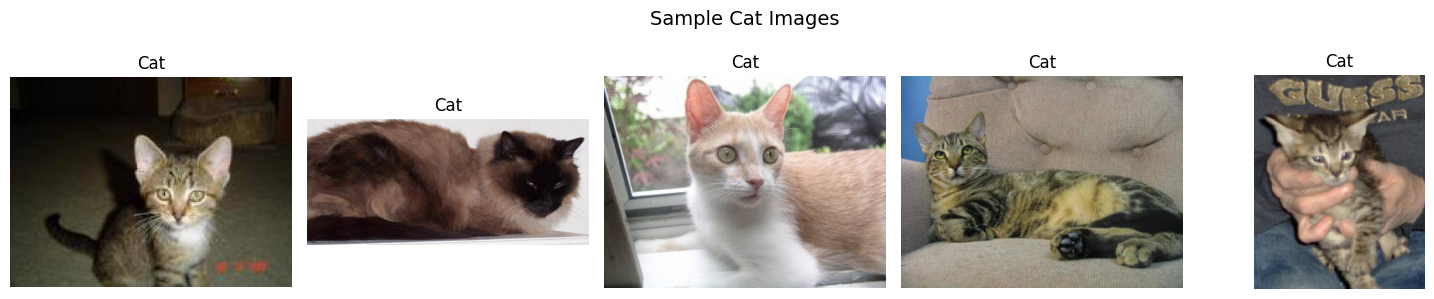

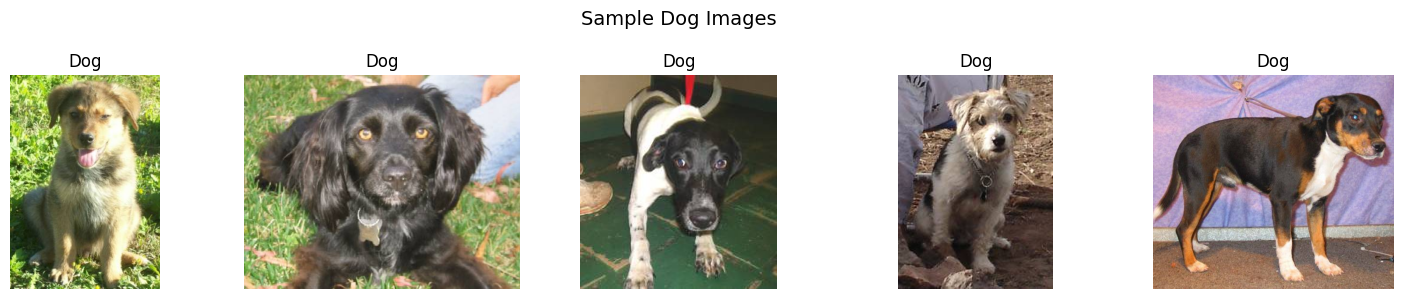

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Visualize samples
def show_images(label):
    img_folder = os.path.join(new_base_dir, 'train', label)
    img_files = random.sample(os.listdir(img_folder), 5)

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(img_files):
        img_path = os.path.join(img_folder, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(label.capitalize())
        plt.axis('off')
    plt.suptitle(f"Sample {label.capitalize()} Images", fontsize=14)
    plt.tight_layout()
    plt.show()

show_images('cat')
show_images('dog')

#### **Load and Rescale Image Data (Train, Validation, Test)**

To ensure consistent input for neural networks, we normalize image pixel values from [0, 255] to [0, 1]. This is done using the `rescale` parameter of `ImageDataGenerator`.

We'll create three generators:
- `Train_generator` for training
- `Validation_generator` for validation
- `Test_generator` for final evaluation

All three will use rescaled images for consistent performance.


In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image parameters
img_size = (180, 180)

# Step 1: Define data generators with rescaling
print("Creating image data generators with rescaling...")

datagen = ImageDataGenerator(rescale=1./255)

# Step 2: Train Generator
print("\nLoading Training Data...")
Train_generator = datagen.flow_from_directory(
    directory=os.path.join(new_base_dir, "train"),
    target_size=img_size,
    class_mode="binary",
    shuffle=True
)

# Step 3: Validation Generator
print("\nLoading Validation Data...")
Validation_generator = datagen.flow_from_directory(
    directory=os.path.join(new_base_dir, "validation"),
    target_size=img_size,
    class_mode="binary",
    shuffle=False
)

# Step 4: Test Generator
print("\nLoading Test Data...")
Test_generator = datagen.flow_from_directory(
    directory=os.path.join(new_base_dir, "test"),
    target_size=img_size,
    class_mode="binary",
    shuffle=False
)


Creating image data generators with rescaling...

Loading Training Data...
Found 2000 images belonging to 2 classes.

Loading Validation Data...
Found 1000 images belonging to 2 classes.

Loading Test Data...
Found 2000 images belonging to 2 classes.


#### **Visualize Sample Images from Generators**

Let's confirm that the images are correctly reshaped and rescaled by plotting a sample batch from the training dataset.


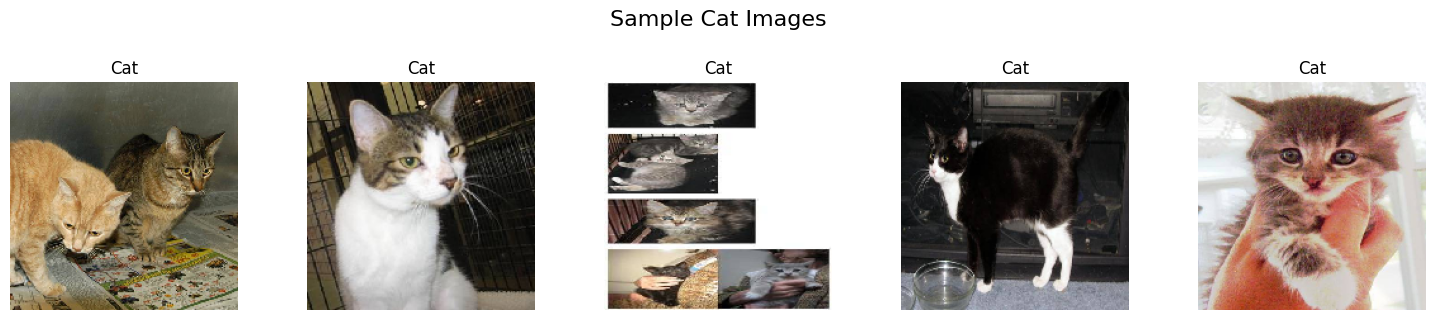

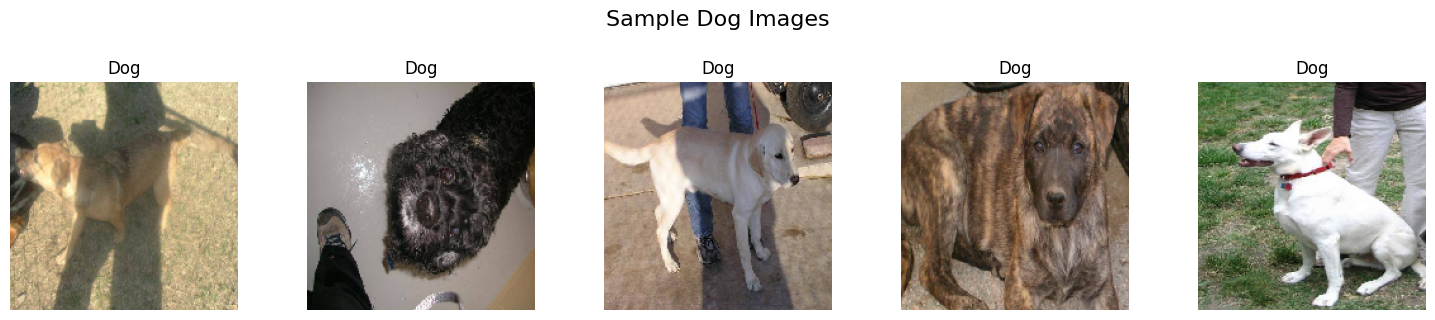

In [6]:
# Fetch one batch from the train generator
images, labels = next(Train_generator)

# Separate images into cats and dogs
cat_images = [img for img, label in zip(images, labels) if label == 0]
dog_images = [img for img, label in zip(images, labels) if label == 1]

# Display 5 cat images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cat_images[i])
    plt.title("Cat")
    plt.axis("off")
plt.suptitle("Sample Cat Images", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Display 5 dog images
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(dog_images[i])
    plt.title("Dog")
    plt.axis("off")
plt.suptitle("Sample Dog Images", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


#### **Model 1: Custom Convolutional Neural Network (CNN)**

This model uses three convolutional layers followed by max-pooling, flattening, and two dense layers. The final output layer uses a sigmoid activation for binary classification (Cat vs. Dog). The network is compiled with binary cross-entropy and Adam optimizer.


In [7]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

In [8]:
# Callback to save best model
cnn_checkpoint = ModelCheckpoint("Models/cnn.keras", save_best_only=True, monitor='val_loss')

# Train CNN
history_cnn = cnn_model.fit(
    Train_generator,
    epochs=10,
    validation_data=Validation_generator,
    callbacks=[cnn_checkpoint]
)

Epoch 1/10
63/63 [==============================] - 78s 1s/step - loss: 0.7533 - accuracy: 0.5480 - val_loss: 0.6867 - val_accuracy: 0.6080
Epoch 2/10
63/63 [==============================] - 60s 947ms/step - loss: 0.6487 - accuracy: 0.6350 - val_loss: 0.6414 - val_accuracy: 0.6200
Epoch 3/10
63/63 [==============================] - 58s 917ms/step - loss: 0.6026 - accuracy: 0.6840 - val_loss: 0.7224 - val_accuracy: 0.5860
Epoch 4/10
63/63 [==============================] - 60s 948ms/step - loss: 0.5840 - accuracy: 0.6915 - val_loss: 0.6494 - val_accuracy: 0.6450
Epoch 5/10
63/63 [==============================] - 59s 932ms/step - loss: 0.5195 - accuracy: 0.7395 - val_loss: 0.6576 - val_accuracy: 0.6680
Epoch 6/10
63/63 [==============================] - 59s 938ms/step - loss: 0.4187 - accuracy: 0.8045 - val_loss: 0.6368 - val_accuracy: 0.6800
Epoch 7/10
63/63 [==============================] - 59s 930ms/step - loss: 0.3388 - accuracy: 0.8495 - val_loss: 0.7479 - val_accuracy: 0.6760
Ep

#### **Training and Validation Curves for Custom CNN**

The following plots show how the model performed during training. The accuracy and loss graphs help evaluate whether the model is overfitting, underfitting, or learning appropriately.


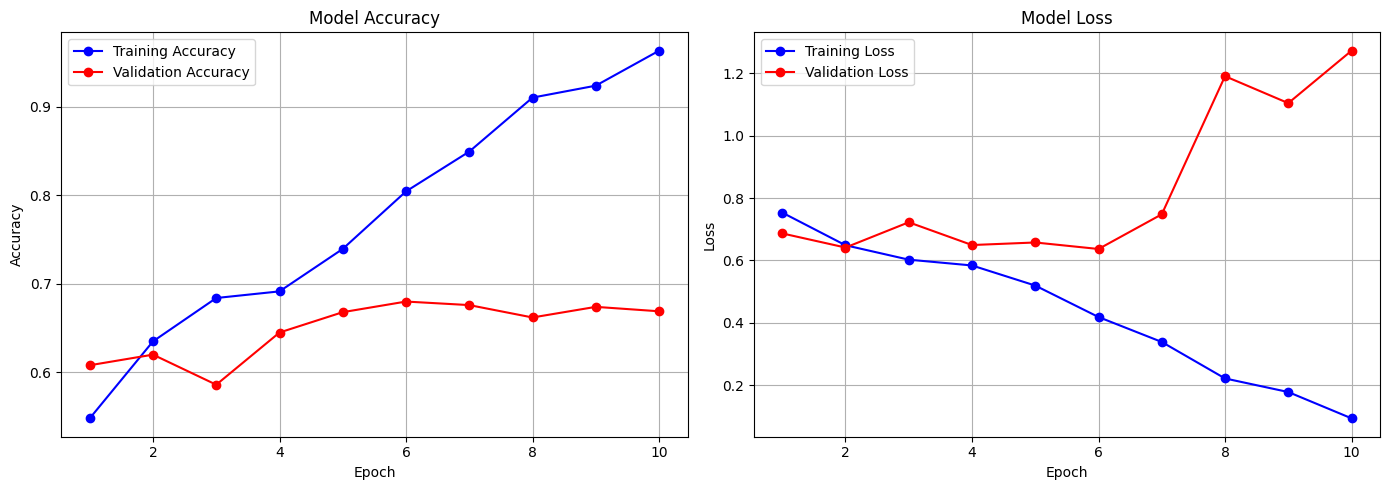

In [9]:
import matplotlib.pyplot as plt

# Extract history data
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting the curves
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### **Model Evaluation on Test Set**

The best version of the model (lowest validation loss) is loaded and evaluated on the unseen test set to measure its generalization capability. This includes accuracy, confusion matrix, and classification metrics.


63/63 [==============================] - 17s 269ms/step - loss: 0.6661 - accuracy: 0.6745

Test Accuracy: 0.6745
Test Loss: 0.6661
63/63 [==============================] - 15s 224ms/step

Classification Report:

              precision    recall  f1-score   support

         Cat       0.69      0.65      0.66      1000
         Dog       0.67      0.70      0.68      1000

    accuracy                           0.67      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000



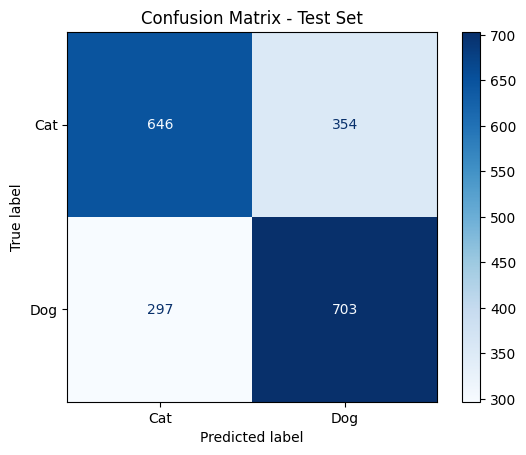

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Load best saved model
best_model = load_model("Models/cnn.keras")

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(Test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predict labels
y_pred_prob = best_model.predict(Test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
y_true = Test_generator.classes

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()


### **Model 2: Fine-Tune VGG16 (pre-trained on imagenet). Make sure to use validation to test for over-fitting. Plot the appropriate graph**

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze base layers before fine-tuning
conv_base.trainable = False


In [ ]:
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 17,992,001
Trainable params: 3,277,313
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
# Callback to save best model (based on validation loss)
checkpoint_cb = ModelCheckpoint(
    "Models/vgg16.keras",
    save_best_only=True,
    monitor="val_loss"
)

# Fit the model
history_vgg = model.fit(
    Train_generator,
    epochs=10,
    validation_data=Validation_generator,
    callbacks=[checkpoint_cb]
)

Epoch 1/10
16/63 [======>.......................] - ETA: 3:46 - loss: 0.6810 - accuracy: 0.6089

KeyboardInterrupt: 

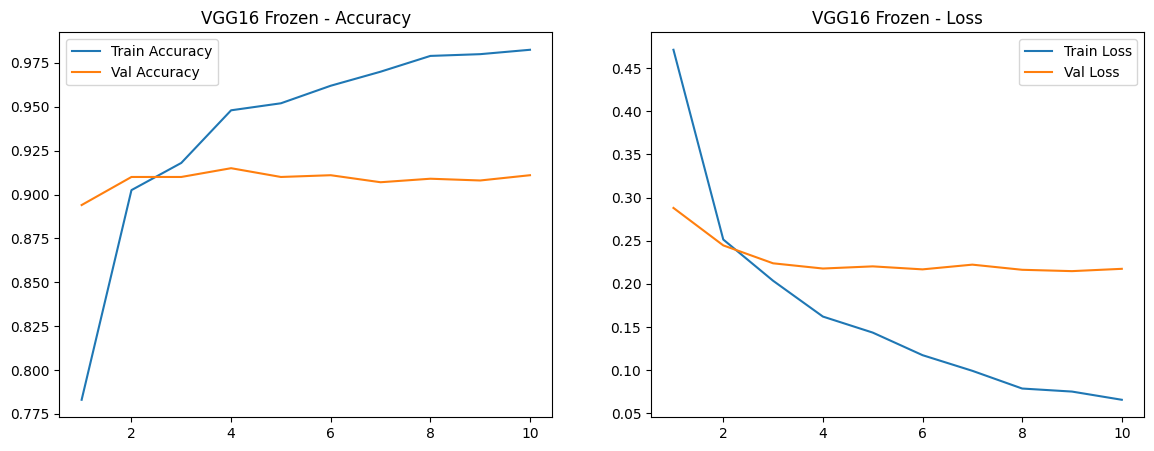

In [ ]:
def plot_metrics(history_vgg, title_prefix="VGG16 Frozen"):
    acc = history_vgg.history['accuracy']
    val_acc = history_vgg.history['val_accuracy']
    loss = history_vgg.history['loss']
    val_loss = history_vgg.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title(f'{title_prefix} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{title_prefix} - Loss')
    plt.legend()

    plt.show()

plot_metrics(history_vgg)